<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Построение-прогностической-модели" data-toc-modified-id="Построение-прогностической-модели-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Построение прогностической модели</a></span><ul class="toc-item"><li><span><a href="#Подбор-признаков" data-toc-modified-id="Подбор-признаков-0.2.1"><span class="toc-item-num">0.2.1&nbsp;&nbsp;</span>Подбор признаков</a></span></li><li><span><a href="#Разделение-датасета-на-тестовую-и-обучающую-выборки" data-toc-modified-id="Разделение-датасета-на-тестовую-и-обучающую-выборки-0.2.2"><span class="toc-item-num">0.2.2&nbsp;&nbsp;</span>Разделение датасета на тестовую и обучающую выборки</a></span></li><li><span><a href="#Создание-метрики-RMSE" data-toc-modified-id="Создание-метрики-RMSE-0.2.3"><span class="toc-item-num">0.2.3&nbsp;&nbsp;</span>Создание метрики RMSE</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-0.2.4"><span class="toc-item-num">0.2.4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Предсказание-тренда" data-toc-modified-id="Предсказание-тренда-0.2.4.1"><span class="toc-item-num">0.2.4.1&nbsp;&nbsp;</span>Предсказание тренда</a></span></li><li><span><a href="#Предсказание-сезонности" data-toc-modified-id="Предсказание-сезонности-0.2.4.2"><span class="toc-item-num">0.2.4.2&nbsp;&nbsp;</span>Предсказание сезонности</a></span></li><li><span><a href="#Предсказание-остатков" data-toc-modified-id="Предсказание-остатков-0.2.4.3"><span class="toc-item-num">0.2.4.3&nbsp;&nbsp;</span>Предсказание остатков</a></span></li></ul></li><li><span><a href="#Создание-дополнительных-признаков" data-toc-modified-id="Создание-дополнительных-признаков-0.2.5"><span class="toc-item-num">0.2.5&nbsp;&nbsp;</span>Создание дополнительных признаков</a></span><ul class="toc-item"><li><span><a href="#Предсказание-тренда" data-toc-modified-id="Предсказание-тренда-0.2.5.1"><span class="toc-item-num">0.2.5.1&nbsp;&nbsp;</span>Предсказание тренда</a></span></li><li><span><a href="#Предсказание-сезонности" data-toc-modified-id="Предсказание-сезонности-0.2.5.2"><span class="toc-item-num">0.2.5.2&nbsp;&nbsp;</span>Предсказание сезонности</a></span></li><li><span><a href="#Предсказание-остатков" data-toc-modified-id="Предсказание-остатков-0.2.5.3"><span class="toc-item-num">0.2.5.3&nbsp;&nbsp;</span>Предсказание остатков</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Вторая-итерация-обучения" data-toc-modified-id="Вторая-итерация-обучения-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Вторая итерация обучения</a></span><ul class="toc-item"><li><span><a href="#Подбор-дополнительных-признаков-и-гиперпараметров-для-градиентного-бустинга" data-toc-modified-id="Подбор-дополнительных-признаков-и-гиперпараметров-для-градиентного-бустинга-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Подбор дополнительных признаков и гиперпараметров для градиентного бустинга</a></span></li><li><span><a href="#Обучение-лучшей-модели" data-toc-modified-id="Обучение-лучшей-модели-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Обучение лучшей модели</a></span></li></ul></li></ul></div>

In [1]:
import time

from datetime import datetime

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose\

import lightgbm as lgb

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error as mse
from sklearn.preprocessing import OneHotEncoder

## Анализ данных

In [2]:
try:
    data = pd.read_csv('taxi.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [3]:
data.sample(3)

,datetime,num_orders
11915,2018-05-22 17:50:00,9
23540,2018-08-11 11:20:00,13
12558,2018-05-27 05:00:00,13


In [4]:
def full_info(df):
    display(pd.DataFrame({'Non-Null Count': (~df.isna()).sum(), 
                          'Null Count': df.isna().sum(), 
                          'Dtype': df.dtypes}).join(df.describe().T).rename_axis('Feature', axis=1).fillna(''))

In [5]:
print(full_info(data));

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
datetime,26496,0,object,,,,,,,,
num_orders,26496,0,int64,26496,14.0705,9.21133,0,8,13,19,119


None


В датасете 26496 наблюдений, пропусков нет, но врменной признак имеет невременной формат. Распределение числа заказов выглядит равномерным, рассмотрим его детальнее.

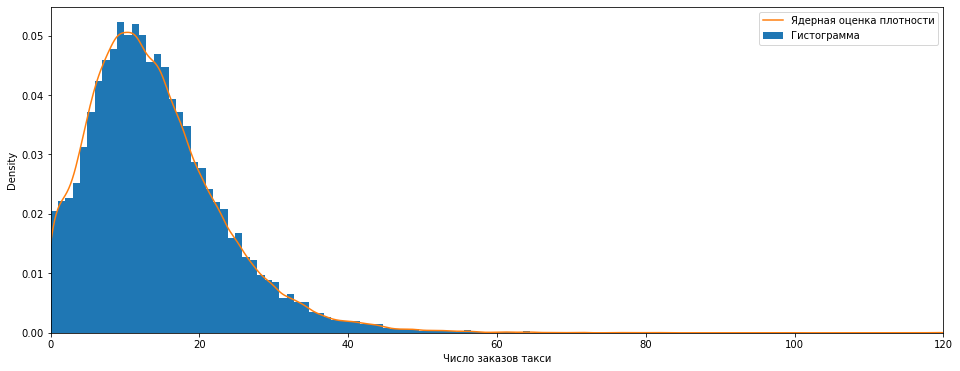

In [6]:
plt.figure(figsize=(16, 6))
data['num_orders'].hist(bins=120, density=True)
data['num_orders'].plot.kde(bw_method=0.1)
plt.xlim([0,120]);
plt.legend(['Ядерная оценка плотности', 'Гистограмма']);
plt.xlabel('Число заказов такси');

Распределение выглядит равномерным. Можно легко представить, что за шесть месяцев однажды случалось более ста вызово такси за десять минут.

Приведем признак `datetime` к временному типу

In [7]:
data['datetime'] = pd.to_datetime(data['datetime'])

Проверим, не отличался ли промежуток между измерениями

In [8]:
(data['datetime'] - data['datetime'].shift()).value_counts()

0 days 00:10:00    26495
Name: datetime, dtype: int64

Перенесем временной признак в индексы

In [9]:
data.index = data['datetime']

Проведем ресемплинг по одному часу, приняв за агрегированное значение суммарное число заказов такси за период

In [10]:
data = data.resample('1H').sum();

In [11]:
data.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


Разделим дату на временные атрибуты. Имеет смысл выделить цикличные параметры (день недели, час в рамках суток).

In [12]:
data['hour'] = data.index.hour
data['day'] = data.index.day
data['day_index'] = data.index.dayofweek
data['day_name'] = data.index.day_name()
data['month'] = data.index.month
data['month_name'] = data.index.month_name()

In [13]:
data.sample(3)

,num_orders,hour,day,day_index,day_name,month,month_name
datetime,,,,,,,
2018-08-26 02:00:00,148,2,26,6,Sunday,8,August
2018-05-21 21:00:00,93,21,21,0,Monday,5,May
2018-08-15 15:00:00,103,15,15,2,Wednesday,8,August


Разделим временной ряд на составяющие: тренд, сезонность и остатки

In [14]:
decomposed = seasonal_decompose(data['num_orders']) 

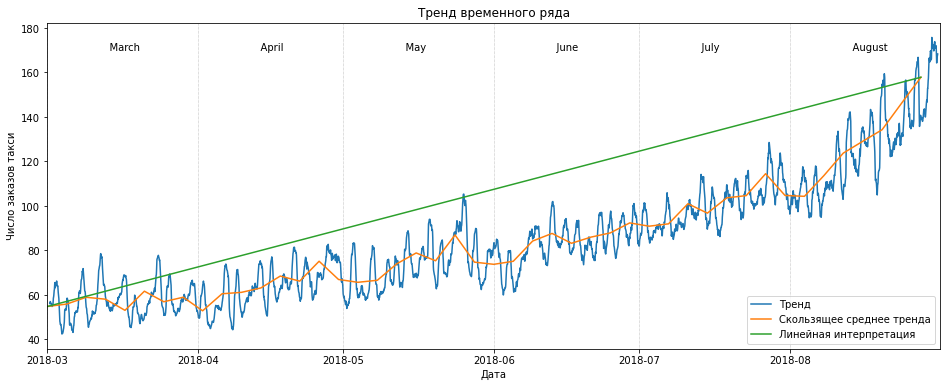

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(decomposed.trend)
plt.plot(decomposed.trend.resample('96H').mean())
plt.plot(decomposed.trend.resample('96H').mean().iloc[np.r_[0:1, -1:0]])
plt.legend(['Тренд', 'Скользящее среднее тренда', 'Линейная интерпретация'], loc='lower right');
plt.xlim([data.index[0], data.index[-1]])
plt.title('Тренд временного ряда')
plt.xlabel('Дата')
plt.ylabel('Число заказов такси')
for index in data['month_name'].drop_duplicates().index:
    plt.axvline(x=index, color='grey', linewidth=0.5, linestyle=':')
    plt.text(index, 170, 20*' '+data['month_name'].drop_duplicates().loc[index])

Тренд показывает монотонный, но не линейный рост. Посмотрим на график логарифма тренда

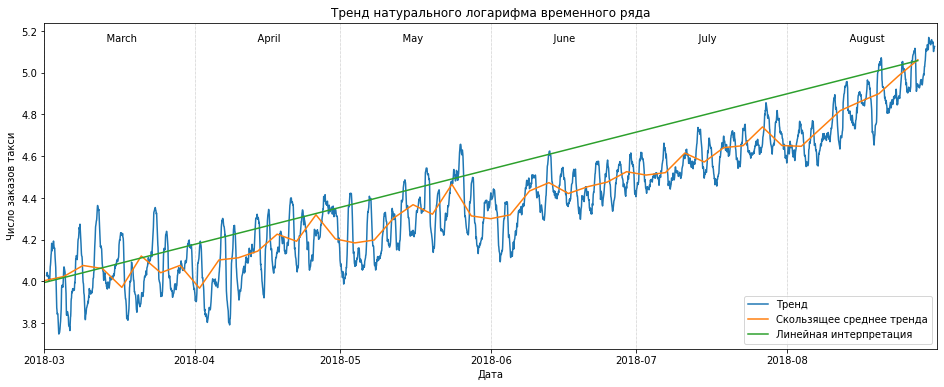

In [16]:
plt.figure(figsize=(16, 6))
plt.plot(np.log(decomposed.trend))
plt.plot(np.log(decomposed.trend.resample('96H').mean()))
plt.plot(np.log(decomposed.trend).resample('96H').mean().iloc[np.r_[0:1, -1:0]])
plt.legend(['Тренд', 'Скользящее среднее тренда', 'Линейная интерпретация'], loc='lower right');
plt.xlim([data.index[0], data.index[-1]])
plt.title('Тренд натурального логарифма временного ряда')
plt.xlabel('Дата')
plt.ylabel('Число заказов такси')
for index in data['month_name'].drop_duplicates().index:
    plt.axvline(x=index, color='grey', linewidth=0.5, linestyle=':')
    plt.text(index, 5.15, 20*' '+data['month_name'].drop_duplicates().loc[index])

Логарифм целевой переменной визуально ближе к линейной функции, будем предсказывать логарифм целевой переменной. Однако прежде нужно избавиться от нулей в целевом признаке. Удалить ноль мы не можем, так как тогда нарушится структура временного ряда, поэтому заменим ноль соседним значением

In [17]:
display(data[data['num_orders']==0])

,num_orders,hour,day,day_index,day_name,month,month_name
datetime,,,,,,,
2018-04-06 06:00:00,0,6,6,4,Friday,4,April


Выведем окрестности интервала с нулевыми заказами

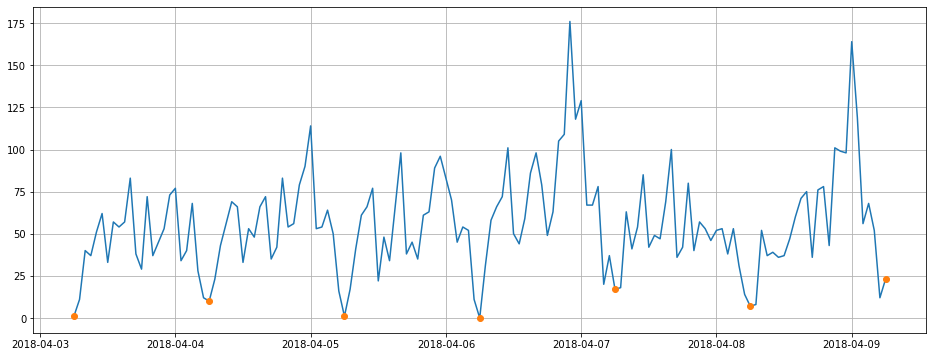

In [18]:
plt.figure(figsize=(16,6))
plt.plot(data['2018-04-03 06:00:00':'2018-04-09 06:00:00']['num_orders']);
plt.plot(data[data['hour']==6]['2018-04-03 06:00:00':'2018-04-09 06:00:00']['num_orders'], linestyle='', marker='o')
plt.grid();

Видно, что как минимум на протяжении недели на 6 утра приходились суточные минимумы заказов такси, поэтому наверняка ноль неслучаен - заказов просто не было. Чтобы не вносить большой погрешности в реальные данные и одновременно соблюсти математическую строгость, заменим ноль на ближайшее целое логарифмируемое число - единицу.

In [19]:
data['num_orders'].replace(0, 1, inplace=True)
display(data[data['num_orders']==0])

,num_orders,hour,day,day_index,day_name,month,month_name
datetime,,,,,,,


Определим цикличность временного ряда в рамках одной случайной недели

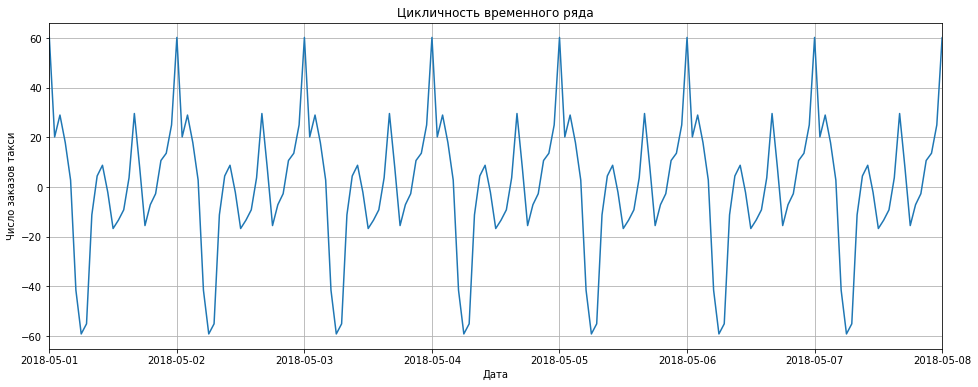

In [20]:
plt.figure(figsize=(16, 6))
plt.plot(decomposed.seasonal['2018-05-01':'2018-05-08'])
plt.xticks(decomposed.seasonal['2018-05-01':'2018-05-08'].resample('24H').sum().index)
plt.xlim(['2018-05-01','2018-05-08'])
plt.title('Цикличность временного ряда')
plt.xlabel('Дата')
plt.ylabel('Число заказов такси')
plt.grid()

Ряд цикличен в пределах суток. Пики заказов приходятся на полночь

Рассмотрим остатки

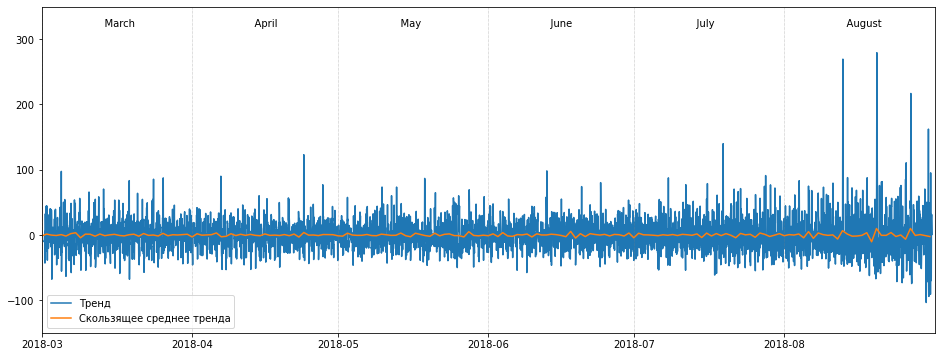

In [21]:
plt.figure(figsize=(16, 6))
plt.plot(decomposed.resid)
plt.plot(decomposed.resid.resample('24H').mean())
plt.legend(['Тренд', 'Скользящее среднее тренда'], loc='lower left');
plt.xlim([data.index[0], data.index[-1]])
plt.ylim([-150, 350])
for index in data['month_name'].drop_duplicates().index:
    plt.axvline(x=index, color='grey', linewidth=0.5, linestyle=':')
    plt.text(index, 320, 20*' '+data['month_name'].drop_duplicates().loc[index])

Шум в данных практически стационарен, однако колебания числа заказов в августе чуть выше, чем в остальные месяцы

Построим общий график временного ряда (сумму тренда, сезонности и шума), а также его стандартное отклонение.

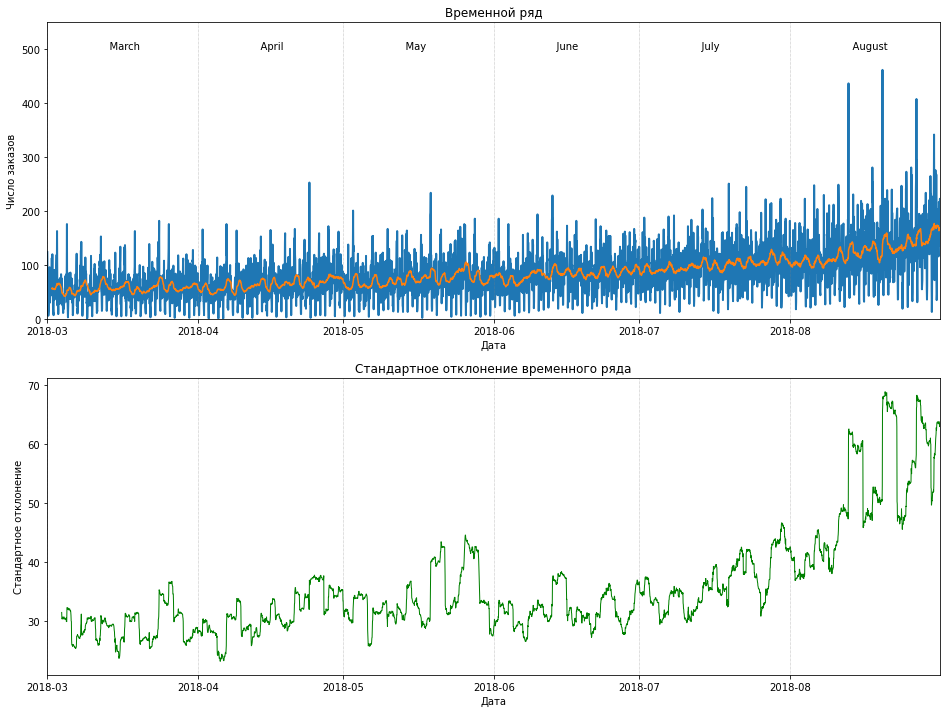

In [22]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
plt.title('Временной ряд')
plt.plot(data['num_orders'], linewidth=2)
plt.plot(data['num_orders'].rolling(24).mean())
plt.xlim([data.index[0], data.index[-1]])
plt.ylim([0,550])
plt.xlabel('Дата')
plt.ylabel('Число заказов');
for index in data['month_name'].drop_duplicates().index:
    plt.axvline(x=index, color='grey', linewidth=0.5, linestyle=':')
    plt.text(index, 500, 20*' '+data['month_name'].drop_duplicates().loc[index])

plt.subplot(2, 1, 2)
plt.title('Стандартное отклонение временного ряда')
plt.plot(data['num_orders'].rolling(72).std(), linewidth=1, c='g')
plt.xlim([data.index[0], data.index[-1]])
plt.xlabel('Дата')
plt.ylabel('Стандартное отклонение');
for index in data['month_name'].drop_duplicates().index:
    #print(data['month_name'].drop_duplicates().loc[index])
    plt.axvline(x=index, color='grey', linewidth=0.5, linestyle=':')

На общем графике прослеживается и цикличность, и тренд роста, и постепенное увеличение дисперсии.

## Построение прогностической модели

### Подбор признаков

Проанализируем имеющиеся признаки и их ценность для прогноза

In [23]:
data.sample()

,num_orders,hour,day,day_index,day_name,month,month_name
datetime,,,,,,,
2018-06-27 10:00:00,97,10,27,2,Wednesday,6,June


* `num_orders` - целевая переменная
* `hour` - циклически повторяющийся признак
* `day` - число месяца, циклический признак, не отражающий цикличности во временном ряду
* `day_index` - индекс дня недели, дублирует `day_name`
* `day_name` - день недели, номинативный признак
* `month` - номер месяца, важный для линейного тренда признак
* `month_name` - название месяца, признак был бы важен для сезоннной компоненты

В доказательство влияния дня недели на число заказов такси приведем график

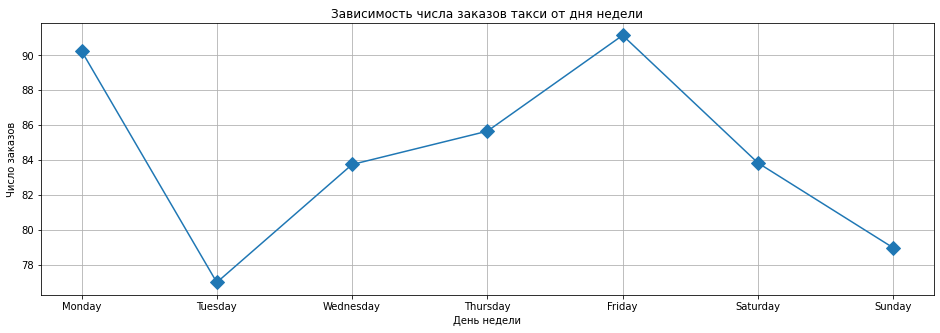

In [24]:
plt.figure(figsize=(16,5))
plt.plot(data.groupby('day_name')[['num_orders', 'day_index']].mean().sort_values(by='day_index')['num_orders'], 
         linestyle='-', 
         marker='D', 
         markersize=10);
plt.title('Зависимость числа заказов такси от дня недели')
plt.xlabel('День недели')
plt.ylabel('Число заказов');
plt.grid()

Удалим ненужные и повторяющиеся признаки

In [25]:
data = data.drop(['month_name', 'month', 'day', 'day_index'], axis=1)

In [26]:
data.sample()

,num_orders,hour,day_name
datetime,,,
2018-08-26 10:00:00,136,10,Sunday


Применим one hot encoder к признаку `day_name`

In [27]:
data = pd.get_dummies(data, columns=['day_name'], drop_first=True)

Улучшить предсказание может помочь знание тренда, опреденного по предыдущим значениям. Также полезно определить скользящее среднее для N предыдыщих значений. Но заранее мы не знаем, сколько предыдущих значений может понадобиться, а также какую оптимальную ширину окна выбрать для скользящего среднего, поэтому напишем функцию, добавляющую к датасету соответствующие признаки

In [28]:
def feature_maker(data, lag_N, window_width):
    df = data.copy()
    for i in range(1, lag_N+1):
        df['lag_{}'.format(i)] = df['num_orders'].shift(i)
        
    df['rm_mean'] = df['num_orders'].shift().rolling(window_width).mean()
        
    return df

Разделим признаки на обучающие и целевые

In [29]:
features = data.drop('num_orders', axis=1)
target = data['num_orders']

### Разделение датасета на тестовую и обучающую выборки

Разделим датасет на тестовую и обучающую выборки.

In [30]:
train_features, test_features, train_target, test_target = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.1, 
                                                                            shuffle=False)

Проверим размеры выборок после разбиения

In [31]:
print('Признаки обучающей выборки: {}'.format(train_features.shape))
print('Таргет обучающей выборки: {}'.format(train_target.shape))
print('Признаки тестовой выборки: {}'.format(test_features.shape))
print('Таргет тестовой выборки: {}'.format(test_target.shape))

Признаки обучающей выборки: (3974, 7)
Таргет обучающей выборки: (3974,)
Признаки тестовой выборки: (442, 7)
Таргет тестовой выборки: (442,)


Разделим целевую переменную из обучающей выборки на составляющие и заполним пропуски

In [32]:
train_trend = seasonal_decompose(train_target).trend.fillna(method='ffill').fillna(method='bfill')
train_seasonal = seasonal_decompose(train_target).seasonal
train_resid = seasonal_decompose(train_target).resid.fillna(method='ffill').fillna(method='bfill')

In [33]:
display('Пропусков в составляющей тренда: {}'.format(train_trend.isna().sum()))
display('Пропусков в сезонной составляющей: {}'.format(train_seasonal.isna().sum()))
display('Пропусков в составляющей шума: {}'.format(train_resid.isna().sum()))

'Пропусков в составляющей тренда: 0'

'Пропусков в сезонной составляющей: 0'

'Пропусков в составляющей шума: 0'

In [34]:
try:
    temp_df = pd.read_csv('taxi.csv')
except:
    temp_df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')
temp_df['datetime'] = pd.to_datetime(temp_df['datetime'])
temp_df.index = temp_df['datetime']
temp_df = temp_df.resample('1H').sum()
temp_decomposed = seasonal_decompose(temp_df['num_orders'])

([], [])

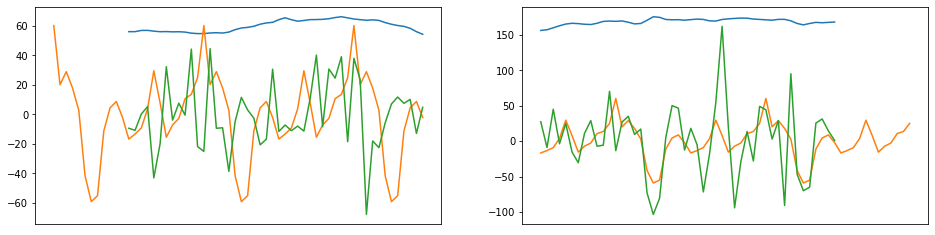

In [35]:
plt.figure(figsize=(16, 4))


plt.subplot(1, 2, 1)
plt.plot(temp_decomposed.trend.head(60))
plt.plot(temp_decomposed.seasonal.head(60))
plt.plot(temp_decomposed.resid.head(60))
plt.xticks([])

plt.subplot(1, 2, 2)
plt.plot(temp_decomposed.trend.tail(60))
plt.plot(temp_decomposed.seasonal.tail(60))
plt.plot(temp_decomposed.resid.tail(60))
plt.xticks([])

Разделим целевую переменную из тестовой выборки на составляющие и заполним пропуски. ~~Хотя трогать тестовую выборку и не очень честно, к сожалению, я довольно поздно обнаружил эти пропуски~~

In [36]:
test_trend = seasonal_decompose(test_target).trend.fillna(method='ffill').fillna(method='bfill')
test_seasonal = seasonal_decompose(test_target).seasonal
test_resid = seasonal_decompose(test_target).resid.fillna(method='ffill').fillna(method='bfill')

In [37]:
display('Пропусков в составляющей тренда: {}'.format(test_trend.isna().sum()))
display('Пропусков в сезонной составляющей: {}'.format(test_seasonal.isna().sum()))
display('Пропусков в составляющей шума: {}'.format(test_resid.isna().sum()))

'Пропусков в составляющей тренда: 0'

'Пропусков в сезонной составляющей: 0'

'Пропусков в составляющей шума: 0'

### Создание метрики RMSE

In [38]:
rmse = make_scorer(mse, squared=False, greater_is_better=False)

### Обучение моделей

Разделение временного ряда на тренд, сезонность и шум показало, что две из трех компоненты почти стационарны, а значит могут быть в первом приближении предсказаны без машинного обучения. Убедимся, что все три компоненты имеют одинаковый размер

In [39]:
print('Размер компоненты тренда: {}'.format(train_trend.shape[0]))
print('Размер сезонной компоненты: {}'.format(train_seasonal.shape[0]))
print('Размер компоненты шума: {}'.format(train_resid.shape[0]))

Размер компоненты тренда: 3974
Размер сезонной компоненты: 3974
Размер компоненты шума: 3974


Построим графики колебания сезонной составляющей для обучающей и тестовой выборок, а также для полного датасета

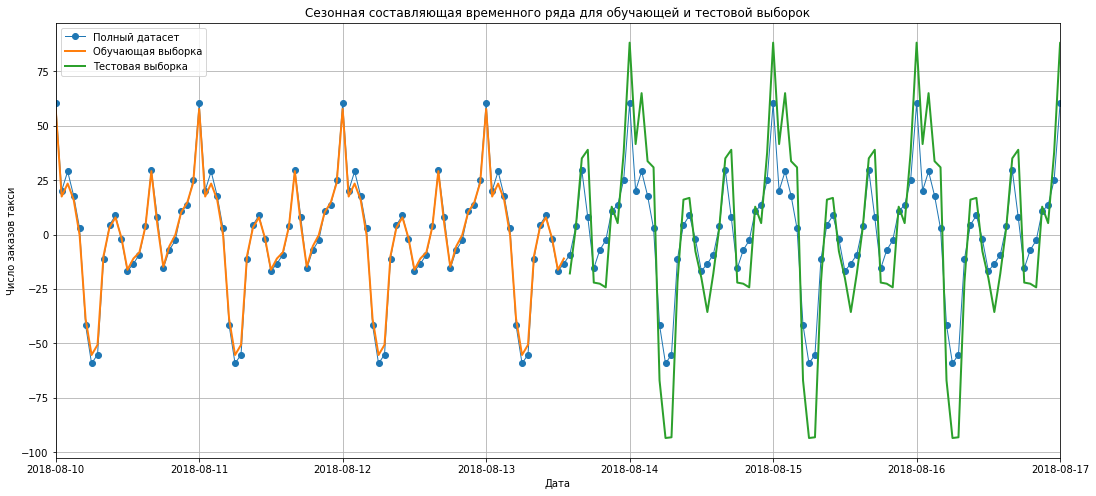

In [40]:
plt.figure(figsize=(18, 8))
plt.title('Сезонная составляющая временного ряда для обучающей и тестовой выборок')
plt.plot(seasonal_decompose(data['num_orders']).seasonal, linewidth=1, linestyle='-', marker='o')
plt.plot(seasonal_decompose(train_target).seasonal, linewidth=2)
plt.plot(seasonal_decompose(test_target).seasonal, linewidth=2)
plt.xlabel('Дата')
plt.ylabel('Число заказов такси')
plt.grid()
plt.legend(['Полный датасет', 'Обучающая выборка', 'Тестовая выборка'])
plt.xlim(['2018-08-10 00:00:00','2018-08-17 00:00:00']);

Графики сезонной составляющей отличаются для обучающей и тестовой выборок, однако общий тренд для них одинаков. И поскольку заранее мы ничего о тестовой выборке не знаем, остается предположить, что суточная динамика зазказов такси останется неизменной.

Напишем функцию, возвращающую предсказание сезонной составляющей ряда на основе данных обучающей выборки

In [41]:
def daily_predictor(train_target, test_features):
    train_target = train_target.resample('1H').mean()
    return seasonal_decompose(train_target).seasonal.head(24).reset_index(drop=True).loc[test_features.index.hour].values

Компонента шума практически постоянна для всего ряда, ее можно предсказать постоянной средней. Убедимся в этом на графике

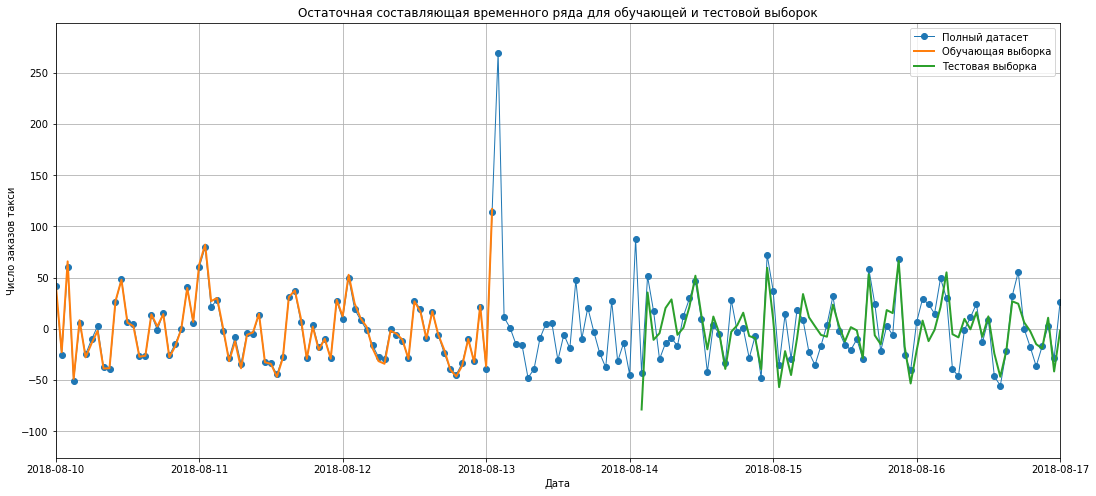

In [42]:
plt.figure(figsize=(18, 8))
plt.title('Остаточная составляющая временного ряда для обучающей и тестовой выборок')
plt.plot(seasonal_decompose(data['num_orders']).resid, linewidth=1, linestyle='-', marker='o')
plt.plot(seasonal_decompose(train_target).resid, linewidth=2)
plt.plot(seasonal_decompose(test_target).resid, linewidth=2)
plt.xlabel('Дата')
plt.ylabel('Число заказов такси')
plt.grid()
plt.legend(['Полный датасет', 'Обучающая выборка', 'Тестовая выборка'])
plt.xlim(['2018-08-10 00:00:00','2018-08-17 00:00:00']);

Напишем функцию, возвращающую предсказание остатков временного ряда на основе обучающей выборки

In [43]:
def resid_predictor(train_target, test_features):
    return test_features.shape[0]*[train_target.mean()]

Для предсказания тренда воспользуемся линейной регрессией. Поскольку логарифм распределения оказался ближе к линейной функции, предсказывать будем логарифм трендовой составляющей, а после этого возьмем от предсказанных значений обратную функцию - экспоненту.

Примем число разбиений в TimeSeriesSplit равным 8, чтобы размер валидационной выборки был равен тестовому на каждом фолде

In [44]:
n_splits = 8

In [45]:
lr_model = LinearRegression()
lr_model.fit(train_features, np.log(train_trend))
trend_predicted = np.exp(lr_model.predict(test_features))
seasonal_predicted = daily_predictor(train_seasonal, test_features)
resid_predicted = resid_predictor(train_resid, test_features)

In [46]:
mse(test_target, trend_predicted + seasonal_predicted + resid_predicted, squared=False)

77.45345896134555

RMSE около 77. Значит, выбранные предсказательные модели не слишком хорошо описывают закономерности. Попробуем подобрать для каждой компоненты собственную модель

#### Предсказание тренда

Переберем вариации линейной регрессии в поисках наиболее хорошо описывающей логарифм тренда временного ряда

##### LinearRegression

In [47]:
lr_model = LinearRegression()

tscv  = TimeSeriesSplit(n_splits=n_splits)

cv_results = cross_val_score(lr_model, train_features, np.log(train_trend), cv=tscv, scoring=rmse).mean()
print(cv_results)

-0.258991706810718


##### Ridge

In [48]:
r_model = Ridge()
r_params = {'alpha': [0.1, 0.5, 0.9]}

r_gs = GridSearchCV(r_model, param_grid=r_params, scoring=rmse, cv=TimeSeriesSplit(n_splits=n_splits))
r_gs.fit(train_features, np.log(train_trend),)
pd.DataFrame(r_gs.cv_results_).sort_values(by='rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012337,0.022864,0.002375,0.000479,0.1,{'alpha': 0.1},-0.111751,-0.162911,-0.183023,-0.271916,-0.250997,-0.295306,-0.375074,-0.420984,-0.258995,0.098710,1
1,0.003740,0.001087,0.002369,0.000483,0.5,{'alpha': 0.5},-0.112016,-0.162841,-0.182955,-0.271909,-0.251003,-0.295305,-0.375044,-0.420994,-0.259008,0.098673,2
2,0.003491,0.000864,0.001995,0.000499,0.9,{'alpha': 0.9},-0.112263,-0.162776,-0.182891,-0.271903,-0.251009,-0.295304,-0.375014,-0.421005,-0.259021,0.098638,3


##### Lasso

In [49]:
l_model = Lasso()
l_params = {'alpha': [0.1, 0.5, 0.9]}

l_gs = GridSearchCV(l_model, param_grid=l_params, scoring=rmse, cv=TimeSeriesSplit(n_splits=n_splits))
l_gs.fit(train_features, np.log(train_trend),)
pd.DataFrame(l_gs.cv_results_).sort_values(by='rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004114,1.265284e-03,0.002369,0.000483,0.1,{'alpha': 0.1},-0.12544,-0.167964,-0.188307,-0.277509,-0.253636,-0.296749,-0.369401,-0.427009,-0.263252,0.095649,1
1,0.002992,5.022377e-07,0.001496,0.000499,0.5,{'alpha': 0.5},-0.12544,-0.167964,-0.188307,-0.277509,-0.253636,-0.296749,-0.369401,-0.427009,-0.263252,0.095649,1
2,0.003366,6.937313e-04,0.001745,0.000432,0.9,{'alpha': 0.9},-0.12544,-0.167964,-0.188307,-0.277509,-0.253636,-0.296749,-0.369401,-0.427009,-0.263252,0.095649,1


##### ElasticNet

In [50]:
en_model = ElasticNet()
en_params = {'alpha': [0.1, 0.5, 0.9], 'l1_ratio': [0.3, 0.5, 0.9]}

en_gs = GridSearchCV(en_model, param_grid=en_params, scoring=rmse, cv=TimeSeriesSplit(n_splits=n_splits))
en_gs.fit(train_features, np.log(train_trend))
pd.DataFrame(en_gs.cv_results_).sort_values(by='rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002992,0.000705,0.001870,0.000598,0.1,0.3,"{'alpha': 0.1, 'l1_ratio': 0.3}",-0.12544,-0.167964,-0.188307,-0.277509,-0.253636,-0.296749,-0.369401,-0.427009,-0.263252,0.095649,1
1,0.003989,0.001115,0.001995,0.000705,0.1,0.5,"{'alpha': 0.1, 'l1_ratio': 0.5}",-0.12544,-0.167964,-0.188307,-0.277509,-0.253636,-0.296749,-0.369401,-0.427009,-0.263252,0.095649,1
2,0.003116,0.000330,0.001621,0.000483,0.1,0.9,"{'alpha': 0.1, 'l1_ratio': 0.9}",-0.12544,-0.167964,-0.188307,-0.277509,-0.253636,-0.296749,-0.369401,-0.427009,-0.263252,0.095649,1


##### Вывод

Лучше всего с предсказанием справилась обыкновенная линейная регрессия без регуляризации

#### Предсказание сезонности

In [51]:
seasonal_model = RandomForestRegressor()
seasonal_params = {'n_estimators': [10, 15], 'max_depth': [5, 10]}

seasonal_gs = GridSearchCV(seasonal_model, param_grid=seasonal_params, scoring=rmse, cv=TimeSeriesSplit(n_splits=n_splits))
seasonal_gs.fit(train_features, train_seasonal)
pd.DataFrame(seasonal_gs.cv_results_).sort_values(by='rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
2,0.018823,0.002972,0.002738,0.000663,10,10,"{'max_depth': 10, 'n_estimators': 10}",-2.026870e-15,-4.154117e-15,-8.063820e-15,-1.031070e-14,-1.334528e-14,-1.659140e-14,-2.094406e-14,-2.177875e-14,-1.215187e-14,6.871088e-15,1
3,0.029298,0.009577,0.003361,0.000491,10,15,"{'max_depth': 10, 'n_estimators': 15}",-7.397673e-15,-5.540654e-15,-7.472449e-15,-1.372886e-14,-1.575321e-14,-1.951740e-14,-2.287109e-14,-2.309892e-14,-1.442253e-14,6.627664e-15,2
0,0.018833,0.001359,0.002737,0.000431,5,10,"{'max_depth': 5, 'n_estimators': 10}",-5.125630e+00,-5.156565e+00,-4.666079e+00,-4.965659e+00,-5.213332e+00,-5.271843e+00,-5.226870e+00,-5.254758e+00,-5.110092e+00,1.909832e-01,3


Модель очень хорошо уловила цикличные закономерности на обучающей выборке и скорее всего переобучилась

#### Предсказание остатков

In [52]:
resid_model = RandomForestRegressor()
resid_params = {'n_estimators': [10, 15], 'max_depth': [5, 10]}

resid_gs = GridSearchCV(resid_model, param_grid=resid_params, scoring=rmse, cv=TimeSeriesSplit(n_splits=n_splits))
resid_gs.fit(train_features, train_resid)
pd.DataFrame(resid_gs.cv_results_).sort_values(by='rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
3,0.029297,0.004018,0.003367,0.000483,10,15,"{'max_depth': 10, 'n_estimators': 15}",-19.065876,-20.666433,-20.883277,-22.894540,-22.263962,-21.690409,-25.364423,-32.921071,-23.218749,4.051337,1
0,0.017960,0.001888,0.003239,0.000434,5,10,"{'max_depth': 5, 'n_estimators': 10}",-18.730181,-20.840050,-21.123864,-23.141123,-21.452568,-21.897075,-25.850112,-33.354947,-23.298740,4.252670,2
1,0.024553,0.003758,0.003373,0.000485,5,15,"{'max_depth': 5, 'n_estimators': 15}",-18.439403,-20.963011,-21.193433,-23.325260,-21.744793,-21.764149,-25.830423,-33.521034,-23.347688,4.317943,3


Каждая модель по отдельности показала на кросс-валидации хорошие результаты с признаками переобучения. Посмотрим, как хорошо с тестовой выборкой соотноссится сумма трех предсказаний.

In [53]:
lr_model = LinearRegression()
lr_model.fit(train_features, np.log(train_trend))
trend_predicted = np.exp(lr_model.predict(test_features))

In [54]:
seasonal_model = RandomForestRegressor(n_estimators=10, max_depth=10)
seasonal_model.fit(train_features, train_seasonal)
seasonal_predicted = seasonal_model.predict(test_features)

In [55]:
resid_model = RandomForestRegressor(n_estimators=15, max_depth=5)
resid_model.fit(train_features, train_resid)
resid_predicted = seasonal_model.predict(test_features)

In [56]:
print('RMSE: {}'.format(round(mse(test_target, trend_predicted + seasonal_predicted + resid_predicted, squared=False), 2)))

RMSE: 76.12


С добавлением модели случайного леса к предсказанию сезонности и остатков RMSE улучшилась, однако по-прежнему остается высокой. 

### Создание дополнительных признаков

Посмотрим, как на точность предсказания повлияет добавление вспомогательных признаков: отстающих значений и скользящего среднего. Так как заранее мы не знаем, какие параметры оптимальны, переберем их в цикле, а на каждой итерации будем обучать модели предсказания компонент временного ряда.

In [57]:
%%time
# Создание датафрейма с результами расчетов
trend_res = pd.DataFrame(columns=['lag_N', 'window_width', 'cv_score', 'params'])
seasonal_res = pd.DataFrame(columns=['lag_N', 'window_width', 'cv_score', 'params'])
resid_res = pd.DataFrame(columns=['lag_N', 'window_width', 'cv_score', 'params'])

# Определение границы между обучающей и тестовой выборкой
train_test_border = data.index[round(0.9*data.shape[0])]

counter=0
for lag in range(1, 20, 5):
    for width in range(1, 20, 5):
        counter+=1
        df = feature_maker(data, lag, width)
        df = df.dropna(axis=0)
        
        # Разделение датасета на обучающую и тестовую выборки
        train = df[df.index<train_test_border]
        #test = df[df.index>train_test_border]
        
        # Разделение выборок на признаки и таргет
        train_features = train.drop('num_orders', axis=1)
        train_target = train['num_orders']
        #test_features = test.drop('num_orders', axis=1)
        #test_target = test['num_orders']
        
        # Разделение признаков на компоненты
        train_trend = seasonal_decompose(train_target).trend.fillna(method='ffill').fillna(method='bfill')
        train_seasonal = seasonal_decompose(train_target).seasonal
        train_resid = seasonal_decompose(train_target).resid.fillna(method='ffill').fillna(method='bfill')
        
        #test_trend = seasonal_decompose(test_target).trend.fillna(method='ffill').fillna(method='bfill')
        #test_seasonal = seasonal_decompose(test_target).seasonal
        #test_resid = seasonal_decompose(test_target).resid.fillna(method='ffill').fillna(method='bfill')
        
        # Модель предсказания тренда
        trend_model = LinearRegression()
        cv_results = cross_val_score(trend_model, train_features, np.log(train_trend), cv=TimeSeriesSplit(n_splits=n_splits), scoring=rmse).mean()
        trend_res.loc[counter, 'lag_N'] = lag
        trend_res.loc[counter, 'window_width'] = width
        trend_res.loc[counter, 'cv_score'] = cv_results
        trend_res.loc[counter, 'params'] = ''
        
        # Модель предсказания сезонности
        seasonal_model = RandomForestRegressor(random_state=123)
        seasonal_params = {'n_estimators': [5, 10, 15], 'max_depth': [5, 10, 15]}
        seasonal_gs = GridSearchCV(seasonal_model, param_grid=seasonal_params, scoring=rmse, cv=TimeSeriesSplit(n_splits=n_splits))
        seasonal_gs.fit(train_features, train_seasonal)
        seasonal_res.loc[counter, 'lag_N'] = lag
        seasonal_res.loc[counter, 'window_width'] = width
        seasonal_res.loc[counter, 'cv_score'] = seasonal_gs.best_score_
        seasonal_res.loc[counter, 'params'] = seasonal_gs.best_params_.items()
        
        # Модель предсказания остатков
        resid_model = RandomForestRegressor(random_state=123)
        resid_params = {'n_estimators': [5, 10, 15], 'max_depth': [5, 10, 15]}
        resid_gs = GridSearchCV(resid_model, param_grid=resid_params, scoring=rmse, cv=TimeSeriesSplit(n_splits=n_splits))
        resid_gs.fit(train_features, train_resid)
        resid_res.loc[counter, 'lag_N'] = lag
        resid_res.loc[counter, 'window_width'] = width
        resid_res.loc[counter, 'cv_score'] = resid_gs.best_score_
        resid_res.loc[counter, 'params'] = resid_gs.best_params_.items()             

Wall time: 2min 56s


In [58]:
trend_res.sort_values(by='cv_score', ascending=False).head(5)

,lag_N,window_width,cv_score,params
14,16,6,-0.0851578,
13,16,1,-0.0851591,
15,16,11,-0.0851591,
16,16,16,-0.0851591,
12,11,16,-0.0863887,


In [59]:
seasonal_res.sort_values(by='cv_score', ascending=False).head(5)

,lag_N,window_width,cv_score,params
1,1,1,-0.222722,"((max_depth, 15), (n_estimators, 5))"
4,1,16,-0.333955,"((max_depth, 15), (n_estimators, 15))"
3,1,11,-0.349781,"((max_depth, 15), (n_estimators, 5))"
2,1,6,-0.529483,"((max_depth, 15), (n_estimators, 15))"
7,6,11,-1.49984,"((max_depth, 15), (n_estimators, 15))"


In [60]:
resid_res.sort_values(by='cv_score', ascending=False).head(5)

,lag_N,window_width,cv_score,params
14,16,6,-22.2392,"((max_depth, 5), (n_estimators, 15))"
15,16,11,-22.2459,"((max_depth, 5), (n_estimators, 15))"
13,16,1,-22.2723,"((max_depth, 5), (n_estimators, 15))"
12,11,16,-22.2735,"((max_depth, 5), (n_estimators, 15))"
16,16,16,-22.2843,"((max_depth, 5), (n_estimators, 15))"


Оптимальные модели и гиперпараметры для каждой составляющей определены. Обучим каждую модель на своей обучающей выборке и предскажем тестовую целевую переменную

#### Предсказание тренда

In [61]:
# Создание дополнительных признаков
trend_data = feature_maker(data, 16, 6).dropna(axis=0)

# Разделение датасета на обучающую и тестовую выборки
trend_train = trend_data[trend_data.index<train_test_border]
trend_test = trend_data[trend_data.index>train_test_border]

# Выделение признаков
train_features = trend_train.drop('num_orders', axis=1)
test_features = trend_test.drop('num_orders', axis=1)

# Выделение трендовой составляющей в обучающей выборке
train_target = trend_train['num_orders']
train_target_trend = seasonal_decompose(train_target).trend.fillna(method='ffill').fillna(method='bfill')

# Выделение трендовой составляющей в тестовой выборке
test_target = trend_test['num_orders']
test_target_trend = seasonal_decompose(test_target).trend.fillna(method='ffill').fillna(method='bfill')

In [62]:
trend_model = LinearRegression()
trend_model.fit(train_features, np.log(train_target_trend))
trend_predicted = np.exp(trend_model.predict(test_features))
mse(test_target_trend, trend_predicted, squared=False)

33.663539585813304

#### Предсказание сезонности

In [63]:
# Создание дополнительных признаков
seasonal_data = feature_maker(data, 1, 1).dropna(axis=0)

# Разделение датасета на обучающую и тестовую выборки
seasonal_train = seasonal_data[seasonal_data.index<train_test_border]
seasonal_test = seasonal_data[seasonal_data.index>train_test_border]

# Выделение признаков
train_features = seasonal_train.drop('num_orders', axis=1)
test_features = seasonal_test.drop('num_orders', axis=1)

# Выделение сезонной составляющей в обучающей выборке
train_target = seasonal_train['num_orders']
train_target_seasonal = seasonal_decompose(train_target).seasonal.fillna(method='ffill').fillna(method='bfill')

# Выделение сезонной составляющей в тестовой выборке
test_target = seasonal_test['num_orders']
test_target_seasonal = seasonal_decompose(test_target).seasonal.fillna(method='ffill').fillna(method='bfill')

In [64]:
seasonal_model = RandomForestRegressor(max_depth=15, n_estimators=5, random_state=123)
seasonal_model.fit(train_features, train_target_seasonal)
seasonal_predicted = seasonal_model.predict(test_features)
mse(test_target_seasonal, seasonal_predicted, squared=False)

22.739407534446705

#### Предсказание остатков

In [65]:
# Создание дополнительных признаков
resid_data = feature_maker(data, 16, 6).dropna(axis=0)

# Разделение датасета на обучающую и тестовую выборки
resid_train = resid_data[resid_data.index<train_test_border]
resid_test = resid_data[resid_data.index>train_test_border]

# Выделение признаков
train_features = resid_train.drop('num_orders', axis=1)
test_features = resid_test.drop('num_orders', axis=1)

# Выделение остаточной составляющей в обучающей выборке
train_target = resid_train['num_orders']
train_target_resid = seasonal_decompose(train_target).resid.fillna(method='ffill').fillna(method='bfill')

# Выделение остаточной составляющей в тестовой выборке
test_target = resid_test['num_orders']
test_target_resid = seasonal_decompose(test_target).resid.fillna(method='ffill').fillna(method='bfill')

In [66]:
resid_model = RandomForestRegressor(max_depth=5, n_estimators=15, random_state=123)
resid_model.fit(train_features, train_target_resid)
resid_predicted = resid_model.predict(test_features)
mse(test_target_resid, resid_predicted, squared=False)

46.00461379041203

Вычислим RMSE предскзаания на тестовой выборке

In [67]:
print('RMSE: {}'.format(round(mse(test_target, trend_predicted + seasonal_predicted + resid_predicted, squared=False), 2)))

RMSE: 74.05


Метрика улучшилась. Сравним предсказанный и тестовый ряды на графике

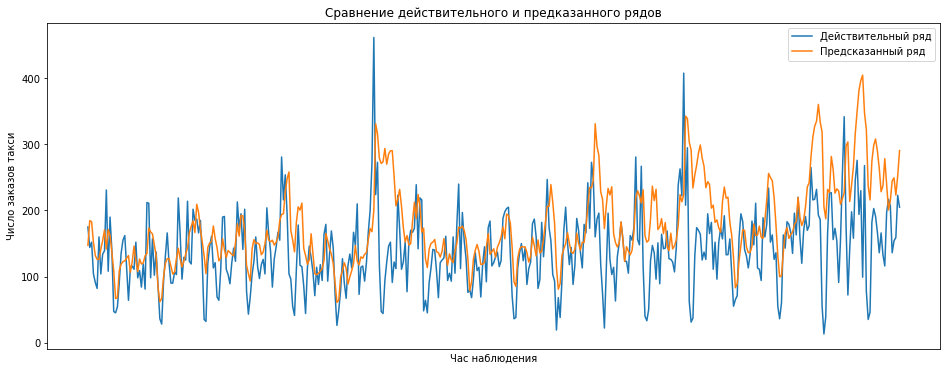

In [68]:
plt.figure(figsize=(16, 6))
plt.title('Сравнение действительного и предказанного рядов')

plt.plot(test_target.values)
plt.plot(trend_predicted + seasonal_predicted + resid_predicted);
plt.xticks([])
plt.xlabel('Час наблюдения')
plt.ylabel('Число заказов такси')

plt.legend(['Действительный ряд', 'Предсказанный ряд']);

***Вывод***

Предсказание довольно точно уловило большинство пиков, хотя у предсказанной величины гораздо большие колебания. Скорее всего это связано с тем, что дисперсия конца ряда (на который как раз пришлась тестовая выборка) растет, но учесть это при обучении заранее было бы трудно.

# Вторая итерация обучения

## Подбор дополнительных признаков и гиперпараметров для градиентного бустинга

In [69]:
try:
    data_original = pd.read_csv('taxi.csv')
except:
    data_original = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')
    
data_original['datetime'] = pd.to_datetime(data_original['datetime'])
data_original.index = data_original['datetime']
data_original = data_original.resample('1H').sum();
data_original['hour'] = data_original.index.hour
data_original['day_name'] = data_original.index.day_name()
data_original['num_orders'].replace(0, 1, inplace=True)
data_original = pd.get_dummies(data_original, columns=['day_name'], drop_first=True)

In [70]:
data2 = data_original

In [71]:
%%time
results = pd.DataFrame(columns=['lag', 'window_width', 'best_params', 'cv_rmse'])
counter=0
for lag in range(1, 20, 5):
    for width in range(1, 20, 5):
        counter+=1
        data2 = feature_maker(data2, lag, width)
        
        features2 = data2.drop('num_orders', axis=1)
        target2 = data2['num_orders']
        
        train_features2, test_features2, train_target2, test_target2 = train_test_split(features2, 
                                                                                target2, 
                                                                                test_size=0.1, 
                                                                                shuffle=False)
        train_features2 = train_features2.dropna(axis=0)
        train_target2 = train_target2[train_features2.index]
        
        lgb_params = {
                       'n_estimators': [1000, 2000],
                       'max_depth': np.arange(1, 20, 5)
                      }
        lgb_gs = GridSearchCV(lgb.LGBMRegressor(), lgb_params, scoring=rmse, cv=TimeSeriesSplit(n_splits=n_splits))
        lgb_gs.fit(train_features2, train_target2)
        
        
        results.loc[counter, 'lag'] = lag
        results.loc[counter, 'window_width'] = width
        results.loc[counter, 'best_params'] = lgb_gs.best_params_.items()
        results.loc[counter, 'cv_rmse'] = lgb_gs.best_score_        

Wall time: 21min 15s


In [72]:
results.sort_values(by='cv_rmse')[::-1].head(3)

,lag,window_width,best_params,cv_rmse
14,16,6,"((max_depth, 16), (n_estimators, 1000))",-24.789
13,16,1,"((max_depth, 11), (n_estimators, 1000))",-24.893
15,16,11,"((max_depth, 16), (n_estimators, 1000))",-24.9367


## Обучение лучшей модели

In [73]:
data3 = data_original

In [74]:
data3 = feature_maker(data3, 16, 6)

In [75]:
features3 = data3.drop('num_orders', axis=1)
target3 = data3['num_orders']

In [76]:
train_features3, test_features3, train_target3, test_target3 = train_test_split(features3, 
                                                                                target3, 
                                                                                test_size=0.1, 
                                                                                shuffle=False)
train_features3 = train_features3.dropna(axis=0)
train_target3 = train_target3[train_features3.index]

In [77]:
%%time
best_model = lgb.LGBMRegressor(max_depth=16, n_estimators=1000)
best_model.fit(train_features3, train_target3)
best_predicted3 = best_model.predict(test_features3)
print(mse(test_target3, best_predicted3, squared=False))

41.594677178097356
Wall time: 1.64 s


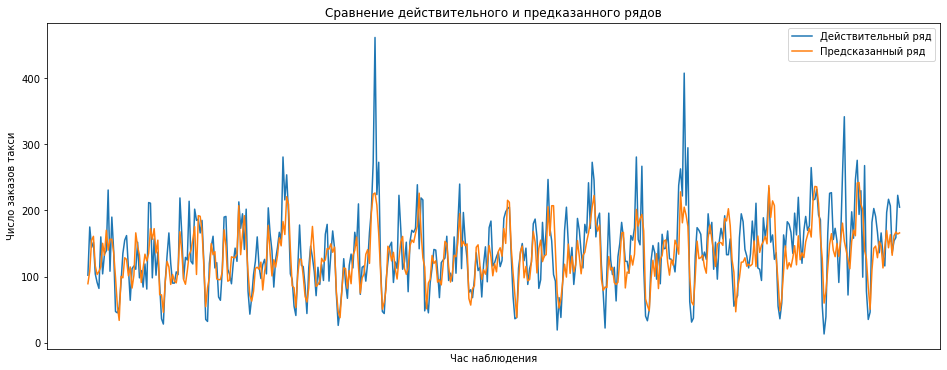

In [78]:
plt.figure(figsize=(16, 6))
plt.title('Сравнение действительного и предказанного рядов')

plt.plot(test_target3.values)
plt.plot(best_predicted3);
plt.xticks([])
plt.xlabel('Час наблюдения')
plt.ylabel('Число заказов такси')

plt.legend(['Действительный ряд', 'Предсказанный ряд']);

*** Вывод ***

Иногда короткий путь - правда самый короткий)